# Sniffing out Democrats and Republicans around Reddit

### Table of Contents
#### Notebook 1: Establishing basic model
* Ground Rules and assumptions
* Package imports
* Get base data to fit model guesser
* Create custom functions used to simplify process
* fit model and establish transformation 
* Basic Data Summary statistics
* Visualizing the Data
#### Notebook 2: Evaluating Random subreddits
* Ground Rules and assumptions
* Package imports
* Get base data to fit model guesser
* Create custom functions used to simplify process
* fit model and establish transformation (everything is the same up to here)
* Evaluate subreddits for political sentiment

## Ground Rules and Assumptions
1. Post titles accurately summarize discussions
2. Distribution of topics in recent posts is the same as that in popular
3. Party word predictors are constant over time
4. Low sarcasm level in the base sets
5. When working with 3 classes:   
  0 Class == Neither, 1 Class == Republican, 2 Class == Democrat   
 When working with 2 classes:
  0 Class == Republican, 1 Class == Democrat

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import requests
import json
import time

from random import randint
from math import exp

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Something to consider: This estimate of prior probability uses the relative number of subscribers for /r/Democrat and /r/Republican to estimate reddit
#Figures as of 8/30/2018
dem_subscribers = 66.2 #Thousand
reb_subscribers = 52.4 #Thousand
dem_prior = dem_subscribers / (dem_subscribers + reb_subscribers)
rep_prior = 1 - dem_prior
dem_prior 

0.5581787521079259

## Initial Pull (needed for fit_transform function default inputs)
As part of the model development process, two sets of requests from /r/democrats and /r/Republican were pulled down on 8.31 and 9.03 to be static basepoints. These are preserved at the top of this notebook as a baseline. It may be advisable to go back and update this later to avoid news topics from that week. This will presumably entail additional calibration of systematic error.

In the first attempt to run this model, it became apparent that having only 2 classes created a lot of false positive words. Apparently, reddit communities discuss similar things. Therefore, a third null class was added to catch all the reddit-y words not overwise eliminated in the stop words. This consists of the following popular subs:
* All
* dogs
* cats
* humansbeingbros

Later, we will be able to more decisively compare democrat estimates and republican estiamtes, instead of NOT democrat and democrat.

Fun Fact: /r/Democrat, what you would expect to be the counterpar of /r/Republican, is apparently entirely overrun with trolls. It is not advisable to visit this page, whatever your political leanings. 

In [3]:
#Read in democrat and republican baseline data
df_dems_1 = pd.read_csv('./Data/InitialDemocratsPosts_8_31.csv')
df_dems_2 = pd.read_csv('./Data/InitialDemocratsPosts_9_03.csv')

'''One post (stickied at the top) was locked and showed up in both hits on r/dem. 
Removed it since our model is about number of posts, not strength or relevancy of those posts.'''
df_democrats_all = df_dems_1.append(df_dems_2.iloc[1:, ], ignore_index=True)

df_reps_1 = pd.read_csv('./Data/InitialRepublicanPosts.csv')
df_reps_2 = pd.read_csv('./Data/InitialRepublicanPosts_9_03.csv')
df_republicans_all = df_reps_1.append(df_reps_2, ignore_index=True)

#Null group sets
df_all_init = pd.read_csv('./Data/allPosts_9_04_A.csv')
df_cats_init = pd.read_csv('./Data/catsPosts_9_03_A.csv')
df_dogs_init = pd.read_csv('./Data/dogsPosts_9_03_A.csv')
df_hbb_init = pd.read_csv('./Data/hbbPosts_9_04_A.csv')

#Join all to single dataframe
df_init_DemRep = df_democrats_all.append(df_republicans_all, ignore_index=True, verify_integrity=True)
for df in [df_all_init,df_cats_init, df_dogs_init, df_hbb_init]:
    df_init_DemRep =  df_init_DemRep.append(df, ignore_index=True, verify_integrity=True)
    
#confirm 4004 posts included
print('    Data Shape: ',df_init_DemRep.shape) 
print('    Duplicate headers (expect count 2): ', len([label for label in df_init_DemRep['subreddit'].value_counts().index if label =='democrats' or label =='Republican']))  #Expect 2

#Translate to 0, 1, 2 groups
df_init_DemRep['subred_cat'] = (df_init_DemRep['subreddit']=='democrats')*2 + (df_init_DemRep['subreddit']=='Republican')*1
df_init_DemRep.fillna(' ', inplace=True)
print('    nulls: ', df_init_DemRep.isnull().sum())
print('    new counts: ', df_init_DemRep['subred_cat'].value_counts())

    Data Shape:  (4004, 3)
    Duplicate headers (expect count 2):  2
    nulls:  selftext      0
subreddit     0
title         0
subred_cat    0
dtype: int64
    new counts:  0    2003
2    1001
1    1000
Name: subred_cat, dtype: int64


## Custom Functions

#### Fit Transform
This function works very similar to pipeline, with some added outputs. A base vectorization is chosen with associated transform. It is then fit against a chosen model.   
  
The results of this process are output via global variable exports.   
This function also links features and predict probas for each class and stores dictionary versions for global. 

In [4]:
my_stop_words = stop_words.ENGLISH_STOP_WORDS
#no compelling reason to pull in self-text
df_data = df_init_DemRep.loc[:, ['subred_cat', 'title']]
def fit_transform_model(X=df_data.title, y=df_data.subred_cat, 
                        vecmod='TFID', pred='logreg', 
                        test_size_local=None, random_state_local=42 ):
    """
    X data pre-transform, y data classes.
    vecmod - some vectorizer. Default is TF-ID. Must put fully instatiated vectorizer in here to update
    pred - predictor. default is logisticregression
    test_size_local - split size for train test split
    random_state for train test split
    """
    
    #get vectorizer
    if vecmod == 'TFID':
        vecmod_ = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,3))
    else:
        vecmod_ = vecmod
    
    #TTS, fit transform on x_train, convert back to pd.DataFrame for later feature extraction
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size_local, 
                                                        random_state=random_state_local)
    X_train_transform = vecmod_.fit_transform(X_train).todense()
    df_X_train_transform = pd.DataFrame(X_train_transform, columns=vecmod_.get_feature_names())
    X_test_transform = vecmod_.transform(X_test).todense()
    df_X_test_transform = pd.DataFrame(X_test_transform, columns=vecmod_.get_feature_names())
    
    #predict model
    if pred == 'logreg':
        funct_model_= LogisticRegression()
    else:
        funct_model_ = pred
        
    funct_model_.fit(df_X_train_transform, y_train)
    
    #Export features and scores
    global latest_model, latest_transform, sorted_d_values_none, sorted_d_values_rep, sorted_d_values_dem, train_x, test_x, test_y, train_y
    latest_model = funct_model_ 
    train_x, test_x, train_y, test_y = df_X_train_transform, df_X_test_transform, y_train, y_test
    latest_transform = vecmod_
    
    try:
        #create feature dictionaries of each word for each category. only sorted_d is exported 
        feature_values_none =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[0]))))
        sorted_d_values_none = sorted({(value, key) for (key,value) in feature_values_none.items()}, reverse=True)
        
        feature_values_rep =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[1]))))
        sorted_d_values_rep = sorted({(value, key) for (key,value) in feature_values_rep.items()}, reverse=True)
        
        feature_values_dem =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[2]))))
        sorted_d_values_dem = sorted({(value, key) for (key,value) in feature_values_dem.items()}, reverse=True)

    except:
        print('   broken sorter')
        return funct_model_.score(df_X_test_transform, y_test)
    
    return funct_model_.score(df_X_test_transform, y_test)

#### Get New Data
This function is meant to consolidate the repeated steps of grabbing basic info from subreddit pages, then condensing it to a single DataFrame.
Only subreddit and post title information is pulled for simplicity.     
At the end, prints randomly generated title for future referencing and globally stores data frame as df_lastest_scrape.  
Also prints shape to verify number of records.  

Caution:
1. Save function assumes Data subfolder exists in working directory.  
2. max_pulls defaults to 40 requests to reddit, with 3 second pauses to avoid being blocked. can take 2 minutes to run, and csv is not saved in the interim. 


In [5]:
def subreddit_getter(subreddit_source, your_name_bot, max_pulls=40):
    """Subreddit source is the sub to be pulled from. should be literal string. E.G., /r/football should be input as 'football'
    your_name_bot will be used to associate calls on your machine.
    max_pulls is number of times to query subreddit data
    
    The resulting dataframe from this process is available globally as df_latest_scrape after completion. 
    
    NB: Save function assumes Data subfolder exists in working directory.
    """
    data_list = []
    base_url = "https://www.reddit.com/r/" + subreddit_source + "/.json"
    URL = base_url

    #seems to be a cap around 20 for some smaller subs
    for _ in range(max_pulls):
        try:
            data = requests.get(URL, headers={'User-agent': your_name_bot}).json()

            for i in range(len(data['data']['children'])):
                temp = {}
                temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
                temp['title']=data['data']['children'][i]['data']['title']
                data_list.append(temp)

            new_after = data['data']['after']
            URL = base_url + "?after=" + new_after
            print('    iteration {} worked. URL: {}'.format(step, URL))
                
            time.sleep(3)  #very important to avoid getting locked out by Reddit.
        except: 
            break
    #Create dataframe, write to csv, save to notebook
    df_scrape = pd.DataFrame(data_list)
    random_name = subreddit_source + str(randint(1, 100000)) #Randint used to avoid writing over previous csvs
    df_scrape.to_csv('./Data/' + random_name + '.csv')
    
    global df_latest_scrape
    df_latest_scrape = df_scrape
    
    print('    text file: ', random_name)
    print('    data frame size: ', df_scrape.shape)

#### Subreddit Analyzer
After the model has been fit, we next want to look at a particular subreddit to see if it is more republican or democrat. 

Given the nature of the training data, the model will more than likely just predict neither. However, every post will score somewhere on the Democcratic and Republican scale. 

In [6]:
def subreddit_Analysis(df_data_current_, output_figname=None, bump_dems=True):
    """
    df_data_current is an untransformed dataframe of post titles, with 2 columns: subreddit, and title
    output_figname: if none (default), do not output and save score distribution. otherwise, use name provided. 
    output_figname assumes that there is a subfolder in current working directory:  ./Presentation/Outputfigs/
    bump_dems: if True (default), include systematic adjustment for democratic posts
    """
    #Jump into analysis for this subreddit here from here
    
    X_cur = latest_transform.transform(df_data_current_.title).todense()
    df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur), columns=['Party'])

    df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))
    
    
    '''
    Systematic adjustment for built in model bias. Necessary for intercept tuning in the wild. 
    See discussion: How strong are the resulting proba scores for each post? below
    Arrived at .45 adjustment after calibration. Otherwise, simulates setting intercepts equal to 
    eachother in predicted probas calculation.
    '''
    if bump_dems:
        dem_bump = abs(exp(latest_model.intercept_[2])-exp(latest_model.intercept_[1]))*.45
    else:
        dem_bump = 0
    df_cur_predictions['dem_score'] = df_cur_predictions['dem_score'] + dem_bump
    

    #Number of posts identified in each class
    print('   Initial None Count: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
    print('   Initial Rep Count: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
    print('   Initial Dem Count: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
    print('    Some of initial dem and rep count gives a sense of inherent political-ness of subreddit')
    
    #In this section, we force the model to pick dem or rep for every post. Then we rescore it, and output a nice figure that visualizes the spread 
    '''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
    Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
    df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
    #create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
    df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
    df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']
    #Counts after normalization
    print('   New Dem Count: ', df_cur_predictions['NewDem'].sum())
    print('   New Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
    #Avg aggregate rating - >.5 indicates dem
    print('   New Percent Dem: ', df_cur_predictions['NewDem'].mean())

    #summarize winning scores for each party 
    probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
    min_prob = .5
    dem_probs = []
    rep_probs = []
    for i in range(len(probas)):
        if probas.iloc[i][1] >min_prob:
            rep_probs.append(probas.iloc[i][1])
        elif probas.iloc[i][0]>min_prob:
            dem_probs.append(probas.iloc[i][0])

    net_probs = []
    for i in range(len(probas)):
        net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

    print('   net sum of probas: ', sum(net_probs))
    print('   mode: ', sp.stats.mode(net_probs)) #Handy detector for systematic error, apparently

    #Color graph based on whether democrats or republicans dominate the subreddit
    if df_cur_predictions['NewDem'].mean() > .5: 
        wincolor = 'blue'
    else:
        wincolor = 'red'
    sns.distplot(net_probs, label='rep', color=wincolor)
    
    if output_figname is not None:
        plt.savefig('./Presentation/OutputFigs/' + output_figname + '.png')

## Model Assessment
---

In [7]:
fit_transform_model(test_size_local=.2, 
                    vecmod=CountVectorizer())

0.9038701622971286

##### Here are some things that didn't help:
Taking out all versions of trump using 'stop_words=stop_words.ENGLISH_STOP_WORDS.union({'Trump', 'trump', 'trumps'})'

In [8]:
print('   none indicators:')
for i in range(10):
    print('    ', sorted_d_values_none[i])
#print('    democratic indicators: ', sorted_d[:-10])
print('\n    rep indicators:')
for i in range(10):
    print('    ', sorted_d_values_rep[i])
print('\n    dem indicators:')
for i in range(10):
    print('    ', sorted_d_values_dem[i])

   none indicators:
     (2.3572671219925727, 'help')
     (1.7855020729610782, 'discussion')
     (1.627262985491246, 'cat')
     (1.419506911560178, 'my')
     (1.3375743103473245, 'she')
     (1.2688280372554113, 'breeds')
     (1.1848043598611708, 'this')
     (1.1373400246605465, 'day')
     (1.1317070973006063, 'dog')
     (1.0860553288417103, 'baby')

    rep indicators:
     (2.1213159530757193, 'liberals')
     (1.7909358556075827, 'hc')
     (1.5854804835110008, 'walkaway')
     (1.5839774104808908, 'brennan')
     (1.5818953005616734, 'us')
     (1.5398842771753247, 'socialism')
     (1.4967234026590832, 'left')
     (1.4650326901670627, 'congressional')
     (1.4506919926230086, 'midterm')
     (1.437333352820045, 'illegal')

    dem indicators:
     (2.6091651511881495, 'kavanaugh')
     (2.38048225529262, 'mccain')
     (1.8329198653475567, 'president')
     (1.7121679540284114, 'rourke')
     (1.6898548447211907, 'trump')
     (1.5990500324220753, 'twitter')
     (1.5568

In [9]:
cm = confusion_matrix(test_y, latest_model.predict(test_x))
df_cm = pd.DataFrame(cm, columns=['Predicted None', 'Pred Rep', 'Pred Dem'], index=['Actual None', 'Actual Rep', 'Actual Dem'])
df_cm

,Predicted None,Pred Rep,Pred Dem
Actual None,369,5,3
Actual Rep,22,174,16
Actual Dem,15,16,181


# Baseline Data Set Meta Analysis
---

## Word Cloud

In [10]:
#!pip install wordcloud

In [11]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

In [10]:
none_word_dict = dict(sorted_d_values_none[:50])
rep_word_dict = dict(sorted_d_values_rep[:50])
dem_word_dict = dict(sorted(sorted_d_values_dem[:50]))

In [11]:
rep_word_dict_trans = {}
for key in rep_word_dict.keys():
    new_key_= int(exp(-key)*2000) #watch out for this negative
    while new_key_ in rep_word_dict.keys():
        new_key_+=1 #tie breaker prevents override of values
        print('    ',new_key_)
    rep_word_dict_trans[new_key_] = rep_word_dict[key]
rep_words_str = ''
for key in rep_word_dict_trans.keys():
    rep_words_str = rep_words_str + key*(str(rep_word_dict_trans[key]) + ' ')

In [12]:
dem_word_dict_trans = {}
for key in dem_word_dict.keys():
    new_key_= int(exp(key)*2000)
    while new_key_ in dem_word_dict.keys():
        new_key_+=1
        print('    ',new_key_)
    dem_word_dict_trans[new_key_] = dem_word_dict[key]
dem_words_str = ''
for key in dem_word_dict_trans.keys():
    dem_words_str = dem_words_str + key*(str(dem_word_dict_trans[key]) + ' ')
#dem_word_dict_trans

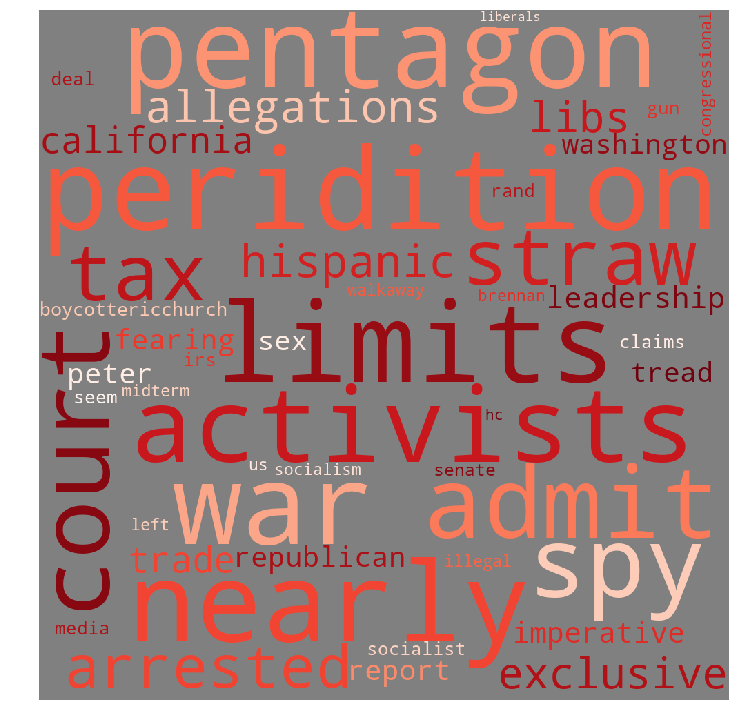

In [13]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    colormap='Reds',
                    min_font_size=1,
                    max_words=len(rep_words_str),
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False).generate_from_text(rep_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/RepCloud_4.png')

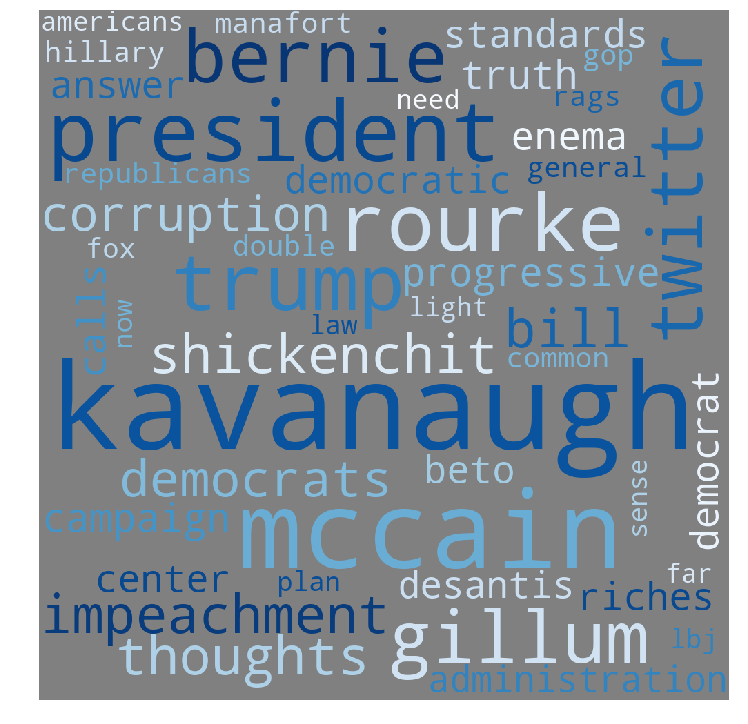

In [14]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    min_font_size=1,
                    colormap='Blues',
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False,
                   max_words=len(dem_words_str)).generate_from_text(dem_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/DemCloud_4.png')

## Word Clustering Analysis - why are scores happening?

In [17]:
#Talk about overlap - words more tightly clustered for republican/

In [18]:
latest_model.intercept_ #Democrat intercept is more penalizing - why?

array([ 1.24750193, -1.51010783, -2.65872772])

In [19]:
#Total Identified words:
len(test_x.columns)

7443

### What is the distribution of Positive Identifiers for each party?

#### How many words are above a given 'strength' score for dems vs. republicans

In [20]:
#Get lists for positive identifiers only, along with their coefficients
all_rep_words = { key:dict(sorted_d_values_rep)[key] for key in dict(sorted_d_values_rep).keys() if key>0 }
all_dem_words = { key:dict(sorted_d_values_dem)[key] for key in dict(sorted_d_values_dem).keys() if key>0 }
print('   Positive Democratic Words:', len(all_dem_words))
print('   Positive Republican Words:', len(all_rep_words))
print('   ', len(all_rep_words)+len(all_dem_words))

   Positive Democratic Words: 1681
   Positive Republican Words: 1545
    3226


In [21]:
max(all_dem_words.keys())

2.6091651511881495

In [24]:
results_list = []
for i in range(4,200, 10):
    j = i/100
    temp_dict = {}
    temp_dict['strength'] = j
    temp_dict['dem_words'] = len([key for key in dict(sorted_d_values_dem).keys() if key>j])
    temp_dict['rep_words'] = len([key for key in dict(sorted_d_values_rep).keys() if key>j])
    results_list.append(temp_dict)

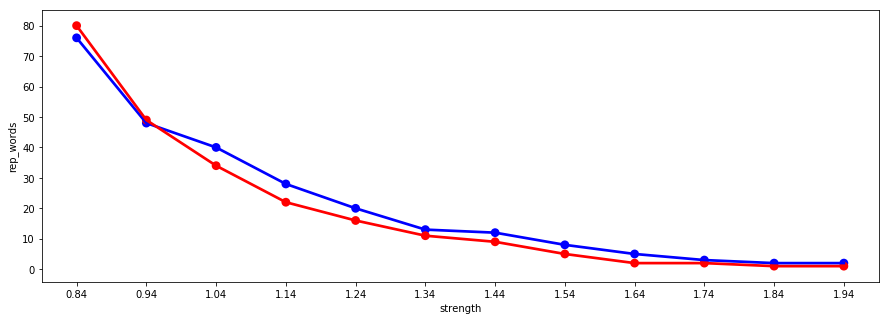

In [25]:
#Let's look at the tails on these positive indicators
df_stregnths = pd.DataFrame(results_list)
df_stregnths = df_stregnths[(df_stregnths['strength']>.8) & (df_stregnths['strength']<4)]
fig, ax2 = plt.subplots(figsize=(15,5))
sns.pointplot('strength','dem_words', data=df_stregnths, color='b', ax=ax2)
sns.pointplot('strength','rep_words', data=df_stregnths, color='r', ax=ax2)

Answer: It looks like Democrats has more words with very high strength scores.  
The intercept on Dems is likely penalizing these.

#### How strong are the resulting proba scores for each post?

    average dem score:  0.2601005463928235
    average rep score:  0.25655631232397336


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


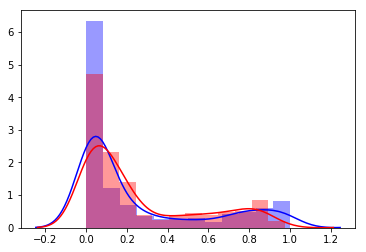

In [26]:
#compare predict probas
probas = latest_model.predict_proba(test_x)
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    rep_probs.append(probas[i][1])
    dem_probs.append(probas[i][2])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')

Answer: Similar to the distribution of the word strengths themselves, the Democratic post scores have a much longer tail. We would expect that if we encounter a post in the wild with a random collection of words, we are more likely to end up with low but positive republican scores. 

## Which posts were the most?

In [27]:
df_checker = pd.DataFrame(pd.Series(test_y))

In [28]:
df_checker['rep_score'] = [probas[i][1] for i in range(len(probas))]
df_checker['dem_score'] = [probas[i][2] for i in range(len(probas))]

In [29]:
#Most republican post
df_checker[df_checker['rep_score']==df_checker['rep_score'].max()]

,subred_cat,rep_score,dem_score
1407,1,0.973863,0.004223


In [30]:
#The most Republican thing you could suggest right now:
#df_init_DemRep.iloc[987:988, :]no selftext...
df_init_DemRep['title'][1407]

'I see Gaza as an open air prison. But I wholeheartedly agree with US approach to UN re: money and help from Arab nations. We do have to stop making US tax payers work for the world while we dont provide enough relief to the tax payers themselves.'

In [31]:
#Most democratic post
df_checker[df_checker['dem_score']==df_checker['dem_score'].max()]

,subred_cat,rep_score,dem_score
17,2,0.000765,0.999227


In [32]:
#The most democratic thing you could suggest right now:
df_init_DemRep['title'][17]

'Republicans will make this election all about race. And the 2020 election, too. -- What’s more, this is the only kind of campaign it can run as long as Trump is president and dominates the party.'